# fig2E_F

Figure generation code specific to the snell's law RF mapping analyses

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle
import scipy.stats as stats
import seaborn as sns

import utils

import matplotlib
from matplotlib.path import Path
import matplotlib.patches as patches
# Set some global plotting styles
matplotlib.rcParams['axes.linewidth'] = 3
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.size'] = 10

%matplotlib notebook
%load_ext autoreload
%autoreload

In [2]:
# Set some variables
ddisp = 0.5
dispcm = 2
dispres=2000

In [3]:
def RFmap_pixel_noloop_gc(center, width, stimpts,fr=None):
    """
    inputs---
    center: RF center, in radian (lat, long)
    width: RF width, in great circle distance (radian)
    stimpts: pts on screen bein`g stimulated (spherical coordinates: lat, long in radian).
    """
    #distance along great circle for each poinmt
    d = np.arccos(np.sin(center[0])*np.sin(stimpts[:,:,0]) + \
              np.cos(center[0])*np.cos(stimpts[:,:,0])*np.cos(stimpts[:,:,1]-center[1]))

    RFout = stats.norm.pdf(d,loc=0,scale=width)

    if fr is not None:
        RFout = RFout*fr

    return RFout

In [4]:
display, tres, spatLUT, spatLUT_inv, h, dSc, dz, fresnel, fresdisplay = utils.read_display(
    'display-dSc_h_0.1_fresdisplay.pickle')
fr = np.zeros((dispres*2,dispres*2))
fr[dispres:,dispres:] = fresdisplay
fr[dispres:,:dispres] = fresdisplay[:,::-1] 
fr[:dispres,:dispres] = fresdisplay[::-1,::-1]
fr[:dispres,dispres:] = fresdisplay[::-1,:] 

dy = np.concatenate((display[::-1,:,:],display),axis=0)
dy[:dispres,:,1] = dispres - dy[:dispres,:,1]
dy[dispres:,:,1] = dispres + dy[dispres:,:,1]

dz = np.concatenate((dy[:,::-1,:],dy[:,:,:]),axis=1)
dz[:,:dispres,0] = dispres - dz[:,:dispres,0]
dz[:,dispres:,0] = dispres + dz[:,dispres:,0]

In [5]:
dy[np.isnan(dy[:,:,0]),0] = 0
dy[np.isnan(dy[:,:,1]),1] = dispres

In [6]:
# Use for control, no distortion case
dx = np.zeros([4000,2000,2])
dx[:,:,0] = np.tile(range(2000),[4000, 1])
ok = np.zeros((4000,1))
ok[:,0] = range(4000)
ok = np.tile(ok,[1, 2000])
dx[:,:,1] = ok
dx.shape

(4000, 2000, 2)

## Steps for keeping solid angle of RF constant for RF mapping:
- Convert all screen coordinates into spherical coordinates
- Establish center point of RF, based on projecting center point onto sphere. This will now have a reference longitude and latitude.
- Calculate great circle distance between all spherical screen points and this reference point. This is in degrees
- Set RF a width in great circle distance and draw from a Gaussian normally
- This will create a heatmap in screen coordinates
- Get FWHM on screen and project border onto sphere, use sinusoidal projection to calculate the area

In [7]:
# If regenerate is True, regenerates required quantities. Otherwise, we load them in
regenerate = False

In [8]:
if regenerate:
    # Transform dy into spherical coordinates
    t, psi, theta = utils.border_to_sphere((dx[:,:,1].ravel(), dx[:,:,0].ravel()), 
                                     h = round(ddisp*dispres/dispcm),center=dispres)

    t, psi_sn, theta_sn = utils.border_to_sphere((dy[:,:,1].ravel(), dy[:,:,0].ravel()), 
                                     h = round(ddisp*dispres/dispcm),center=dispres)

    # Set up transformation matrices
    spts = np.zeros_like(dx)
    spts[:,:,0] = np.reshape(theta,(dx.shape[0], dx.shape[1])) - np.pi/2
    spts[:,:,1] = np.reshape(psi,(dx.shape[0], dx.shape[1]))

    spts_snell = np.zeros_like(dy)
    spts_snell[:,:,0] = np.reshape(theta_sn,(dy.shape[0], dy.shape[1])) - np.pi/2
    spts_snell[:,:,1] = np.reshape(psi_sn,(dy.shape[0], dy.shape[1]))
    
    f = open('spts_dSc_d_0.1.pickle','wb')
    cPickle.dump(spts,f)
    cPickle.dump(spts_snell,f)
    f.close()
else:
    #Load in spts
    f = open('spts_dSc_d_0.1.pickle','rb')
    spts = cPickle.load(f)
    spts_snell = cPickle.load(f)
    f.close()
    
if regenerate:
    #set up search grid
    ares = 50
    sigres = 10
    anglist = np.linspace(5,75,ares)
    siglist = np.linspace(1,55,sigres)

    #set up data matrices
    maxpos = np.zeros((len(siglist),len(anglist)))
    maxpos_snell = np.zeros((len(siglist),len(anglist)))
    area = np.zeros((len(siglist),len(anglist)))
    area_snell = np.zeros((len(siglist),len(anglist)))

    for j in range(len(siglist)):
        print(j)
        for i in range(len(anglist)):
            ang = anglist[i]

            # Given an angle from the eye, get absolute position on screen
            len_ = ddisp*np.tan(ang*np.pi/180)*dispres/dispcm
            x = len_*np.cos(np.pi/4)
            y = len_*np.sin(np.pi/4)
            center = (x,dispres+y)

            # Get spherical coordinates of center point
            o, p, t = utils.border_to_sphere((np.array([center[1]]),np.array([center[0]])), 
                                     h = round(ddisp*dispres/dispcm),center=dispres)

            # RF shape without any distortion
            sn = RFmap_pixel_noloop_gc((t-np.pi/2,p),siglist[j]*np.pi/180,spts)
            area[j,i] = utils.FWHM_border(sn,ddisp,dispres,dispcm)

            # sanity check RF maximum
            mx = np.where(sn==np.nanmax(sn))
            # Find location of maximum
            len_ = np.sqrt((mx[0][0]-dispres)**2+mx[1][0]**2)*dispcm/dispres
            maxpos[j,i] = np.arctan(len_/ddisp)*180/np.pi

            # RF shape with distortion
            snDistort = RFmap_pixel_noloop_gc((t-np.pi/2,p),siglist[j]*np.pi/180,spts_snell,fr[:,2000:])

            # Find distorted RF maximum
            mx = np.where(snDistort==np.nanmax(snDistort))
            # Find location of maximum
            len_ = np.sqrt((mx[0][0]-dispres)**2+mx[1][0]**2)*dispcm/dispres
            maxpos_snell[j,i] = np.arctan(len_/ddisp)*180/np.pi

            # For small RF sigmas, we see no activation on the screen
            if np.nanmax(snDistort) == 0:
                area_snell[j,i] = np.nan
            else:
                area_snell[j,i] = utils.FWHM_border(snDistort,ddisp,dispres,dispcm,thresh=np.nanmax(sn)/20)
                
    #Save all position/size paramaters for loading in later:
    f = open('fig1h_dSc_d_0.1_equidistant.pickle','wb')
    cPickle.dump(anglist,f)
    cPickle.dump(siglist,f)
    cPickle.dump(maxpos,f)
    cPickle.dump(maxpos_snell,f)
    cPickle.dump(area,f)
    cPickle.dump(area_snell,f)
    f.close()
else:
    # Load all position/size parameters
    f = open('fig2f_dSc_d_0.1_equidistant.pickle','rb')
    anglist = cPickle.load(f)
    siglist = cPickle.load(f)
    maxpos = cPickle.load(f)
    maxpos_snell = cPickle.load(f)
    area = cPickle.load(f)
    area_snell = cPickle.load(f)
    f.close()

    f = open('fig2f_dSc_d_10_equidistant.pickle','rb')
    anglist_10 = cPickle.load(f)
    siglist_10 = cPickle.load(f)
    maxpos_10 = cPickle.load(f)
    maxpos_snell_10 = cPickle.load(f)
    area_10 = cPickle.load(f)
    area_snell_10 = cPickle.load(f)
    f.close()

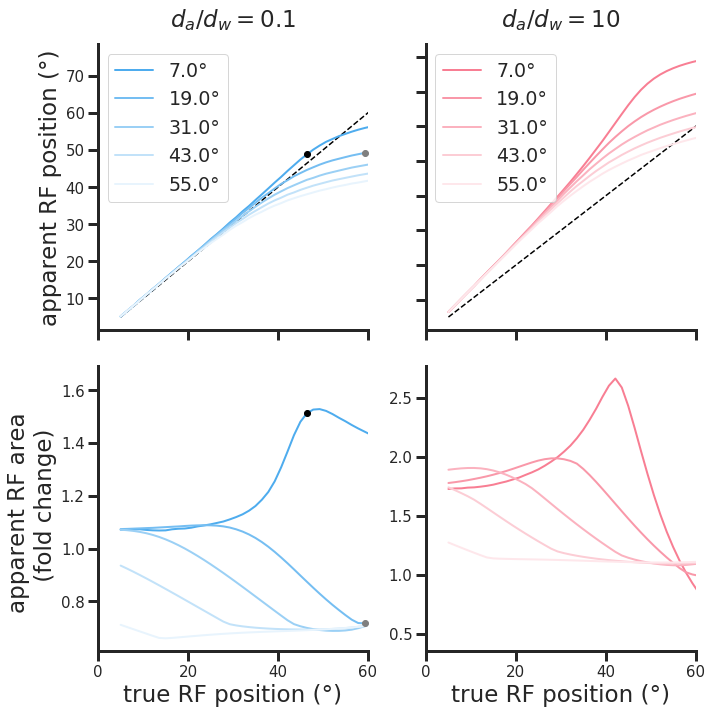

In [9]:
fig = plt.figure(figsize=(10,10))
sns.set_style('ticks',{"xtick.major.size": "10", "ytick.major.size": "10",'axes.linewidth': 3})

a = sns.color_palette("husl",3)
b = sns.light_palette(a[2],reverse=True,n_colors=10)
c = sns.light_palette(a[0],reverse=True,n_colors=10)

ax = plt.subplot(221)
ax.tick_params(width=3,labelsize=15)
plt.plot(anglist,anglist,'--k')
ok = np.arange(10)
for i in range(1,len(ok),2):
    plt.plot(anglist,maxpos_snell[i],color=b[i],linewidth=2,label='{}°'.format(siglist[i]))
    if i == 1:
        plt.plot(anglist[29],maxpos_snell[i,29],'ok')
    if i == 3:
        plt.plot(anglist[38],maxpos_snell[i,38],'o',color='tab:gray')
sns.despine()
plt.title('$d_a/d_w = 0.1$',y=1.04,size=23)
plt.ylabel('apparent RF position (°)',size=23)
plt.xlim([0,60])
plt.xticks([0,20,40,60])
plt.legend(fontsize=19)
ax.xaxis.set_ticklabels([])

#----------------

ax = plt.subplot(222)
ax.tick_params(width=3,labelsize=15)
plt.plot(anglist,anglist,'--k')
for i in range(1,len(ok),2):
    plt.plot(anglist,maxpos_snell_10[i],color=c[i],linewidth=2,label='{}°'.format(siglist[i]))

plt.title('$d_a/d_w = 10$',y=1.04,size=23)
ax.yaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([])
plt.xlim([0,60])
plt.xticks([0,20,40,60])
plt.legend(fontsize=19)

#-------------------

ax = plt.subplot(223)
ax.tick_params(width=3,labelsize=15)
for i in range(1,len(ok),2):
    plt.plot(anglist,area_snell[i]/area[i],color=b[i],linewidth=2)
    if i == 1:
        plt.plot(anglist[29],area_snell[i,29]/area[i,29],'ok')
plt.plot(anglist[38],area_snell[3,38]/area[3,38],'o',color='tab:gray')
sns.despine()
#ax.set_ylim([0, 6])
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
plt.xlim([0,60])
plt.xticks([0,20,40,60])
#ax.set_aspect((x1-x0)/(y1-y0))
plt.xlabel('true RF position (°)',size=23)
plt.ylabel('apparent RF area \n (fold change)',size=23)

#-----------------

ax = plt.subplot(224)
ax.tick_params(width=3,labelsize=15)
for i in range(1,len(ok),2):
    plt.plot(anglist,area_snell_10[i]/area_10[i],color=c[i],linewidth=2)
#ax.set_ylim([0, 6])
sns.despine()
plt.xlim([0,60])
plt.xticks([0,20,40,60])
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
#ax.set_aspect((x1-x0)/(y1-y0))
plt.xlabel('true RF position (°)',size=23)
plt.tight_layout()
#fig.subplots_adjust(hspace=0.2, wspace=-0.2)
#plt.savefig('./paper/v3/fig1h_subplots_v3.pdf')


## Illustrate, for the smallest angular size, how the distortion evolves over position

In [10]:
def show_rf(i,j):
    ang = anglist[i]

    # Given an angle from the eye, get absolute position on screen
    len_ = ddisp*np.tan(ang*np.pi/180)*dispres/dispcm
    x = len_*np.cos(np.pi/4)
    y = len_*np.sin(np.pi/4)
    center = (x,dispres+y)

    # Get spherical coordinates of center point
    o, p, t = utils.border_to_sphere((np.array([center[1]]),np.array([center[0]])), 
                             h = round(ddisp*dispres/dispcm),center=dispres)
    sn = RFmap_pixel_noloop_gc((t-np.pi/2,p),siglist[j]*np.pi/180,spts)
    return sn

def show_rf_distort(i,j):
    ang = anglist[i]

    # Given an angle from the eye, get absolute position on screen
    len_ = ddisp*np.tan(ang*np.pi/180)*dispres/dispcm
    x = len_*np.cos(np.pi/4)
    y = len_*np.sin(np.pi/4)
    center = (x,dispres+y)

    # Get spherical coordinates of center point
    o, p, t = utils.border_to_sphere((np.array([center[1]]),np.array([center[0]])), 
                             h = round(ddisp*dispres/dispcm),center=dispres)
    snDistort = RFmap_pixel_noloop_gc((t-np.pi/2,p),siglist[j]*np.pi/180,spts_snell,fr[:,2000:])
    return snDistort

In [11]:
a = sns.color_palette("husl",3)
c = sns.light_palette(a[0],reverse=True,n_colors=10)
b = sns.light_palette(a[2],reverse=True,n_colors=10)
def draw_border(im,ax):
    #im = sn[2000:,:]
    thresh = np.nanmax(im)/20
    if thresh is None:
        im_ = im>=np.nanmax(im)/2
    else:
        im_ = np.logical_and(im>=np.nanmax(im)/2,im>=thresh)

    border = utils.get_border(im_)

    mean_y = np.mean(border[0])
    mean_x = np.mean(border[1])
    diff_y = border[0]-mean_y
    diff_x = border[1]-mean_x
    a = np.argsort(np.arctan2(diff_y,diff_x))

    border = [border[0],border[1]]

    border[0] = border[0][a]
    border[1] = border[1][a]

    verts = list(zip(border[0],border[1]))
    verts = verts + [verts[0]] # to close the poly

    codes = [Path.MOVETO]
    codes = codes + [Path.LINETO]*(len(verts)-2)
    codes = codes + [Path.CLOSEPOLY]
    path = Path(verts,codes)

    patch = patches.PathPatch(path,facecolor='none',linestyle='dashed',edgecolor=b[0], lw=2)
    ax.add_patch(patch)


In [13]:
angprepx = np.arange(0,80,10)
anginpx = np.arange(0,80,10)
anginpx = ddisp*np.tan(anginpx*np.pi/180)*dispres/dispcm

/home/twd/.conda/envs/snell/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/home/twd/.conda/envs/snell/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/home/twd/.conda/envs/snell/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


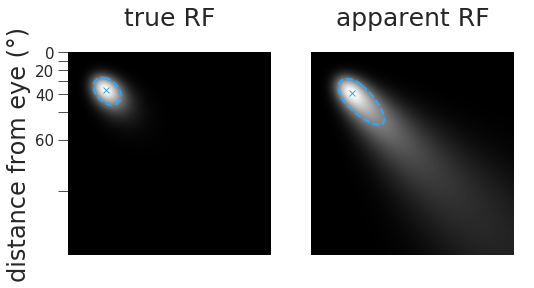

In [24]:
i = 29
j= 1
plt.figure(figsize=(8,8))
plt.subplot(121)
sn = show_rf(i,j)
plt.imshow(sn[2000:,:],cmap='gray')
# Plot center
im_ = sn[2000:,:]
mx = np.where(im_==np.nanmax(im_))
plt.plot(mx[1][0],mx[0][0],'x',color=b[0])

ax = plt.gca()
draw_border(sn[2000:,:],ax)

plt.yticks(anginpx,[0, '', 20, '', 40, '', 60, ''])
plt.xticks([])
ax.tick_params(labelsize=15)
plt.ylabel('distance from eye (°)',fontsize=24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title('true RF',fontsize=25)
ttl = plt.gca().title
ttl.set_position([.5, 1.1])

plt.subplot(122)
snDistort = show_rf_distort(i,j)
plt.imshow(snDistort[2000:,:],cmap='gray')
im_ = snDistort[2000:,:]
mx = np.where(im_==np.nanmax(im_))
plt.plot(mx[1][0],mx[0][0],'x',color=b[0])
ax = plt.gca()
draw_border(snDistort[2000:,:],ax)
plt.title('apparent RF',fontsize=25)
ttl = plt.gca().title
ttl.set_position([.5, 1.1])
plt.axis('off')
#plt.savefig('./fig2ftop.pdf')

/home/twd/.conda/envs/snell/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/home/twd/.conda/envs/snell/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/home/twd/.conda/envs/snell/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.


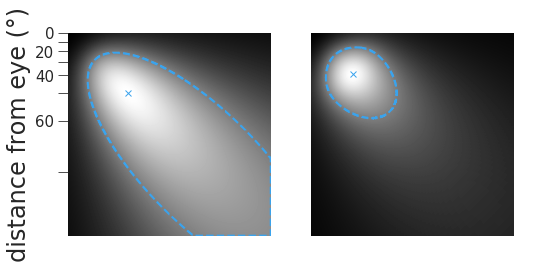

In [22]:
sns.set_style('ticks',{"xtick.major.size": "10", "ytick.major.size": "10",'axes.linewidth': 3})
i = 38
j= 3
plt.figure(figsize=(8,8))
plt.subplot(121)
sn = show_rf(i,j)
plt.imshow(sn[2000:,:],cmap='gray')
im_ = sn[2000:,:]
mx = np.where(im_==np.nanmax(im_))
plt.plot(mx[1][0],mx[0][0],'x',color=b[0])
ax = plt.gca()
draw_border(sn[2000:,:],ax)
plt.yticks(anginpx,[0, '', 20, '', 40, '', 60, ''])
plt.xticks([])
ax.tick_params(labelsize=15)
plt.ylabel('distance from eye (°)',fontsize=24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.subplot(122)
snDistort = show_rf_distort(i,j)
plt.imshow(snDistort[2000:,:],cmap='gray')
ax = plt.gca()
im_ = snDistort[2000:,:]
mx = np.where(im_==np.nanmax(im_))
plt.plot(mx[1][0],mx[0][0],'x',color=b[0])
draw_border(snDistort[2000:,:],ax)
plt.axis('off')
#plt.savefig('./fig2fbottom.pdf')